# FEV vs. RSA Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **RSA (Spearman correlation)**.

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

- The RSA class computes the **Spearman correlation** between RDMs of SimCLR features and neural data. Neural RDMs are built from a single PC (euclidean), and compared to feature RDMs to assess representational similarity 
  
- For features, dimensionality varies across SimCLR layers, so for each layer, the features are reduced to a fixed number of PCs (e.g. 50), to normalise

In [1]:
from cortexlib.rsa import RSA
from cortexlib.utils import file as futils
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tqdm.notebook import tqdm
import pandas as pd

logger = Logger()
set_global_seed()

In [ ]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}") 

18:17:44 | INFO     | ℹ️ This notebook is running for mouse m03_d4


In [3]:
# For each layer, results has an FEV score for predicting neural data from SimCLR features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
37,fc,10.0,0.017885,0.112667
2,layer1,20.0,0.026393,0.126966
9,layer2,NaN,0.030758,0.177962
18,layer3,NaN,0.036175,0.157423
27,layer4,NaN,0.022729,0.112540


In [4]:
simclr_data = futils.load_model_features(futils.Model.SIMCLR, MOUSE_ID)
simclr_feats = simclr_data['features']

18:17:44 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m03_d4/_model_features/simclr_features_mouse_m03_d4.pt


In [5]:
neural_data = futils.load_filtered_neural_data(MOUSE_ID)
neural_responses_mean = neural_data['neural_responses_mean']

18:17:45 | INFO     | ℹ️ Loading filtered neural data from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m03_d4/_neural_data/neural_data_mouse_m03_d4.pt


In [6]:
rsa = RSA(neural_data=neural_responses_mean)

pcs_list = [None, 10, 20, 50, 100, 200, 300, 400, 500]
rsa_results = []

logger.progress(f"Computing RSA: SimCLR features vs. neural data")
for layer, feats in tqdm(simclr_feats.items(), desc="RSA all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    
    for n_pcs in pcs_list:
        feats_pca = feats if n_pcs is None else PCA(n_pcs).fit_transform(feats)
        sim = rsa.compute_similarity_with_neural_data(feats_pca)
        rsa_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'spearman_correlation': sim,
        })

logger.success(f"RSA complete")

18:17:45 | INFO     | ⏳ Computing RSA: SimCLR features vs. neural data...


RSA all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

18:17:45 | INFO     | ⏳ SimCLR layer1...
18:19:28 | INFO     | ⏳ SimCLR layer2...
18:20:21 | INFO     | ⏳ SimCLR layer3...
18:20:52 | INFO     | ⏳ SimCLR layer4...
18:21:10 | INFO     | ⏳ SimCLR fc...
18:21:16 | SUCCESS  | ✅ RSA complete!


In [7]:
futils.write_json_file(rsa_results, './representational_similarity.json')

In [8]:
rsa_results_df = pd.DataFrame(rsa_results)
rsa_results_df.head(12)

,layer,n_pcs,spearman_correlation
0,layer1,NaN,0.103451
1,layer1,10.0,0.182583
2,layer1,20.0,0.188788
3,layer1,50.0,0.182444
4,layer1,100.0,0.174701
5,layer1,200.0,0.167744
6,layer1,300.0,0.164535
7,layer1,400.0,0.163184
8,layer1,500.0,0.162594
9,layer2,NaN,0.170066


In [9]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
rsa_pcs = rsa_results_df[rsa_results_df['n_pcs'] == 100].reset_index(drop=True)
rsa_pcs

,layer,n_pcs,spearman_correlation
0,layer1,100.0,0.174701
1,layer2,100.0,0.193378
2,layer3,100.0,0.191372
3,layer4,100.0,0.144314
4,fc,100.0,0.153057


In [10]:
merged_results = pd.merge(best_fev_per_layer, rsa_pcs, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,spearman_correlation
0,fc,10.0,0.017885,0.112667,100.0,0.153057
1,layer1,20.0,0.026393,0.126966,100.0,0.174701
2,layer2,NaN,0.030758,0.177962,100.0,0.193378
3,layer3,NaN,0.036175,0.157423,100.0,0.191372
4,layer4,NaN,0.022729,0.112540,100.0,0.144314


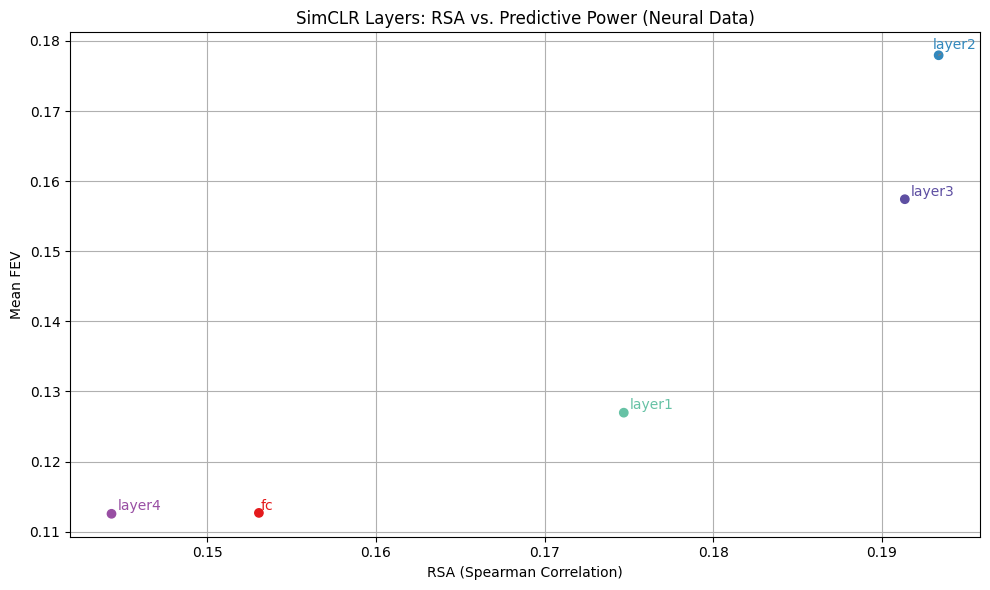

In [11]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['spearman_correlation'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['spearman_correlation'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('RSA (Spearman Correlation)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: RSA vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()